# Voting systems

### Modeling elections as channels

We are gonna start with a simple example to set the scene. Consider the smallest election ever with just 3 voters and 2 candidates.  How can we model that using QIF terminology?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from func import *
try:
    from qif import *
except: # install qif if not available (for running in colab, etc)
    import IPython; IPython.get_ipython().run_line_magic('pip', 'install qif')
    from qif import *

In [2]:
num_voters = 3
num_candidates = 2

We know that a channel takes as input something secret and outputs something public. So what is secret in an election? The votes. But we have 3 persons voting. And each person has 2 possible options for his vote. So in total there are the following $2^3$ scenarios ($c_1$ and $c_2$ below stand for _candidate 1_ and _candidate 2_ respectively):

```
X = {
    c1 c1 c1, 
    c1 c1 c2, 
    c1 c2 c1, 
    c1 c2 c2, 
    c2 c1 c1, 
    c2 c1 c2, 
    c2 c2 c1, 
    c2 c2 c2, 
    }
```


And that is how we can model the votes as our channel's input $X$.

In [3]:
num_combinations = num_candidates ** num_voters

But what would the channel's output be? It depends. It could be just the name of the winning candidate; that is, the candidate which received the most votes. Or it could be for each candidate, the votes they received. Or maybe something else. 

**For the first scenario**, where only the winning candidate is announced, the possible values for output $Y$ are the candidates themselves, i.e.:

```
Y = { c1, c2 }
```

We model this scenario using channel matrix $W$.

$$
\begin{array}{|c|c|c|}
\hline
W & c_1 & c_2 \\ \hline
c_1 c_1 c_1 & 1 & 0 \\ \hline
c_1 c_1 c_2 & 1 & 0 \\ \hline
c_1 c_2 c_1 & 1 & 0 \\ \hline
c_1 c_2 c_2 & 0 & 1 \\ \hline
c_2 c_1 c_1 & 1 & 0 \\ \hline
c_2 c_1 c_2 & 0 & 1 \\ \hline
c_2 c_2 c_1 & 0 & 1 \\ \hline
c_2 c_2 c_2 & 0 & 1 \\ \hline
\end{array}
$$

In [4]:
W = get_W(num_voters, num_candidates)
print(W)

[[1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]]


**For the second scenario**, where the votes for each candidate are announced, the possible values for output $Y$ are:

```
Y = { (3,0), (2,1), (1,2), (0,3) }
```

We model this scenario using channel matrix $C$.

$$
\begin{array}{|c|c|c|}
\hline
C & (3,0) & (2,1) & (1,2) & (0,3) \\ \hline
c_1 c_1 c_1 & 1 & 0 & 0 & 0 \\ \hline
c_1 c_1 c_2 & 0 & 1 & 0 & 0 \\ \hline
c_1 c_2 c_1 & 0 & 1 & 0 & 0 \\ \hline
c_1 c_2 c_2 & 0 & 0 & 1 & 0 \\ \hline
c_2 c_1 c_1 & 0 & 1 & 0 & 0 \\ \hline
c_2 c_1 c_2 & 0 & 0 & 1 & 0 \\ \hline
c_2 c_2 c_1 & 0 & 0 & 1 & 0 \\ \hline
c_2 c_2 c_2 & 0 & 0 & 0 & 1 \\ \hline
\end{array}
$$

In [5]:
C = get_C(num_voters, num_candidates)
print(C)

[[1 0 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 0 1]]


We also assume no prior knowledge about which voter votes for which candidate, so we use a uniform prior.

In [6]:
pi = probab.uniform(num_combinations)
print(pi)

[0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]


### Computing the vulnerability of $W$

If we take a look at the hyper distribution of $W$, we see that each result happens with the same probability and upon observing it, the possible voting combinations have also happen with the same probability.

In [7]:
from print_hyper import print_hyper
print_hyper(W, pi)

-------------------
|    0.50    0.50 |
-------------------
|    0.25    0.00 |
|    0.25    0.00 |
|    0.25    0.00 |
|    0.00    0.25 |
|    0.25    0.00 |
|    0.00    0.25 |
|    0.00    0.25 |
|    0.00    0.25 |
-------------------


So it is natural to expect that $W$'s vulnerability is $0.25$ that is, two times the channel's prior vulnerability (which was equal to $0.125$).

In [8]:
print("Prior bayes vulnerability:", measure.bayes_vuln.prior(pi))
print("Posterior bayes vulnerability of W:", measure.bayes_vuln.posterior(pi, W))
print("Multiplicative leakage of W:", measure.bayes_vuln.mult_leakage(pi, W))

Prior bayes vulnerability: 0.125
Posterior bayes vulnerability of W: 0.25
Multiplicative leakage of W: 2.0


### Computing the vulnerability of $C$

If we do the same thing with $C$, we see that here the different values of $y$ are not equally likely and the resulting posterior vulnerability is $0.5$ that is, $4$ times its prior vulnerability.

In [9]:
from print_hyper import print_hyper
print_hyper(C, pi)

---------------------------------------
|    0.12    0.38    0.38    0.12 |
---------------------------------------
|    1.00    0.00    0.00    0.00 |
|    0.00    0.33    0.00    0.00 |
|    0.00    0.33    0.00    0.00 |
|    0.00    0.00    0.33    0.00 |
|    0.00    0.33    0.00    0.00 |
|    0.00    0.00    0.33    0.00 |
|    0.00    0.00    0.33    0.00 |
|    0.00    0.00    0.00    1.00 |
---------------------------------------


In [10]:
print("Prior bayes vulnerability:", measure.bayes_vuln.prior(pi))
print("Posterior bayes vulnerability of C:", measure.bayes_vuln.posterior(pi, C))
print("Multiplicative leakage of C:", measure.bayes_vuln.mult_leakage(pi, C))

Prior bayes vulnerability: 0.125
Posterior bayes vulnerability of C: 0.5
Multiplicative leakage of C: 4.0


But as someone might expect, these numbers get very small really fast as we consider more voters. That happens because the possible values for $X$, i.e.the voting combinations, grow exponentially to the number of voters. For example for an election of $10$ voters and $2$ candidates we have:

In [11]:
num_voters = 10
num_candidates = 2
num_combinations = num_candidates ** num_voters

In [12]:
print("Prior bayes vulnerability:", measure.bayes_vuln.prior(probab.uniform(num_combinations)))
print()
print("W Posterior bayes vulnerability:", measure.bayes_vuln.posterior(probab.uniform(num_combinations), get_W(num_voters, num_candidates)))
print("W Multiplicative leakage:", measure.bayes_vuln.mult_leakage(probab.uniform(num_combinations), get_W(num_voters, num_candidates)))
print()
print("C Posterior bayes vulnerability:", measure.bayes_vuln.posterior(probab.uniform(num_combinations), get_C(num_voters, num_candidates)))
print("C Multiplicative leakage:", measure.bayes_vuln.mult_leakage(probab.uniform(num_combinations), get_C(num_voters, num_candidates)))

Prior bayes vulnerability: 0.0009765625

W Posterior bayes vulnerability: 0.001953125
W Multiplicative leakage: 2.0

C Posterior bayes vulnerability: 0.0107421875
C Multiplicative leakage: 11.0


Note that $W$'s multiplicative leakage is again $2$, but for $W$ it has jumped up to $11$. And still, $C$ leaks more than $W$.

### Comparing the two channels

Let's see the bigger picture using a graph with the number of voters ranging from $1$ to $12$.

In [13]:
c = 2 # number of candidates
vs = [v for v in range(1, 12)]

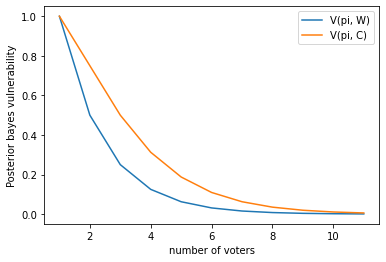

In [14]:
plt.plot(vs, [measure.bayes_vuln.posterior(probab.uniform(c ** v), get_W(v, c)) for v in vs], label="V(pi, W)")
plt.plot(vs, [measure.bayes_vuln.posterior(probab.uniform(c ** v), get_C(v, c)) for v in vs], label="V(pi, C)")
plt.xlabel('number of voters')
plt.ylabel('Posterior bayes vulnerability')
plt.legend()
None

Here we see that $C$ exposes always more than $W$ does. And that would not be a surprise to someone if they have observed that $C$ is a post processing of $W$ or in other words, $C$ is a refinement of $W$. 

That can also be realized more intuitevly if you think of the process of announcing the winner of the election. First they count the votes for each candidate (which is what $W$ does), then they compare them and see who has the most and then they announce the winners name. So the process of comparing the votes for each candidate and deciding who has the most is the post processing of $W$.

This can also be done using a post process matrix $R$.

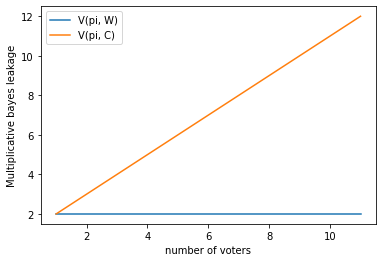

In [15]:
plt.plot(vs, [measure.bayes_vuln.mult_leakage(probab.uniform(c ** v), get_W(v, c)) for v in vs], label="V(pi, W)")
plt.plot(vs, [measure.bayes_vuln.mult_leakage(probab.uniform(c ** v), get_C(v, c)) for v in vs], label="V(pi, C)")
plt.xlabel('number of voters')
plt.ylabel('Multiplicative bayes leakage')
plt.legend()
None

Another interesting fact comes from observing each channel's multiplicative leakage. While $W$'s leakage stays $2$ no matter the number of voters, $C$' leakage increases linearly. This comes from the fact that as the number of voters increases, the number of possible outcomes also increases ending up we have a more detailed partition of $Y$. Thus we can make a better guess once we observe that specific result. 

But in general both posterior vulnerabilities drops down to $0$ very fast, so from around $6$ voters or more we could argue that our secret is quite safe. **But safe against who?** Until now we used bayes vulnerability which corresponds to an adversary trying to correctly guess _the whole voting combination_ that occured. But that is usually not the case. More on part 2.